In [211]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [212]:
# Load the dataset
data_path = 'updated_with_cities.csv'
df = pd.read_csv(data_path)

In [213]:
df.drop(['Unnamed: 0', 'latitude', 'longitude', 'house_keywords'], axis=1, inplace=True)

In [214]:
# Replace '\N' with NaN
df.replace('\\N', np.nan, inplace=True)

In [215]:
# Define categorical and numerical columns
categorical_cols = ['house_type', 'neighbourhood_quality', 'house_condition', 'crime_rate', 'city']
numerical_cols_regression = ['bedrooms', 'bathrooms', 'garden_size'] 
numerical_cols_clustering = ['bedrooms', 'bathrooms', 'garden_size', 'price']

In [216]:
# ColumnTransformer for Clustering
column_transformer_clustering = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols_clustering)
    ],
    remainder='passthrough'  # Ensuring all other columns not specified pass through unchanged
)

In [217]:
# Convert categorical columns to type 'category' if not already
for col in categorical_cols:
    if df[col].dtype != 'category':
        df[col] = df[col].astype('category')


In [218]:
# ColumnTransformer for Regression
column_transformer_regression = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols_regression)
    ],
    remainder='passthrough'  # Handling other columns that are not listed
)

In [219]:
# Handle missing values if any (optional, based on your data)
df.fillna({
    'bedrooms': df['bedrooms'].median(),
    'bathrooms': df['bathrooms'].median(),
    'garden_size': df['garden_size'].median(),
    'house_type': df['house_type'].mode()[0],
    'neighbourhood_quality': df['neighbourhood_quality'].mode()[0],
    'house_condition': df['house_condition'].mode()[0],
    'crime_rate': df['crime_rate'].mode()[0],
    'city': df['city'].mode()[0]
}, inplace=True)

In [220]:
# Regression Pipeline
pipeline_regression = Pipeline([
    ('preprocessor', column_transformer_regression),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

In [221]:
# Setup clustering pipeline
pipeline_clustering = Pipeline([
    ('preprocessor', column_transformer_clustering),
    ('cluster', KMeans(n_clusters=5, random_state=42))
])

In [222]:
# Prepare the full dataset for clustering
X_clustering = df[categorical_cols + numerical_cols_clustering]


X_regression = df[categorical_cols + numerical_cols_regression]  # Exclude price here
y = df['price']

In [223]:
# Fit and transform using the appropriate pipeline
df['Cluster'] = pipeline_clustering.fit_predict(X_clustering)

In [224]:
# Split the data for regression
X_train, X_test, y_train, y_test = train_test_split(X_regression, y, test_size=0.2, random_state=42)
pipeline_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['house_type',
                                                   'neighbourhood_quality',
                                                   'house_condition',
                                                   'crime_rate', 'city']),
                                                 ('num', StandardScaler(),
                                                  ['bedrooms', 'bathrooms',
                                                   'garden_size'])])),
                ('regressor', DecisionTreeRegressor(random_state=42))])

In [225]:
# Predictions and evaluations
y_pred = pipeline_regression.predict(X_test)
print("Predicted Prices:", y_pred)

Predicted Prices: [411865.92 185455.5  122753.2  ... 852898.87 262552.62 488559.17]


In [226]:
# Display the data types of each column
print(df.dtypes)


house_type               category
price                     float64
bedrooms                    int64
bathrooms                   int64
neighbourhood_quality    category
house_condition          category
crime_rate               category
garden_size               float64
city                     category
Cluster                     int32
dtype: object


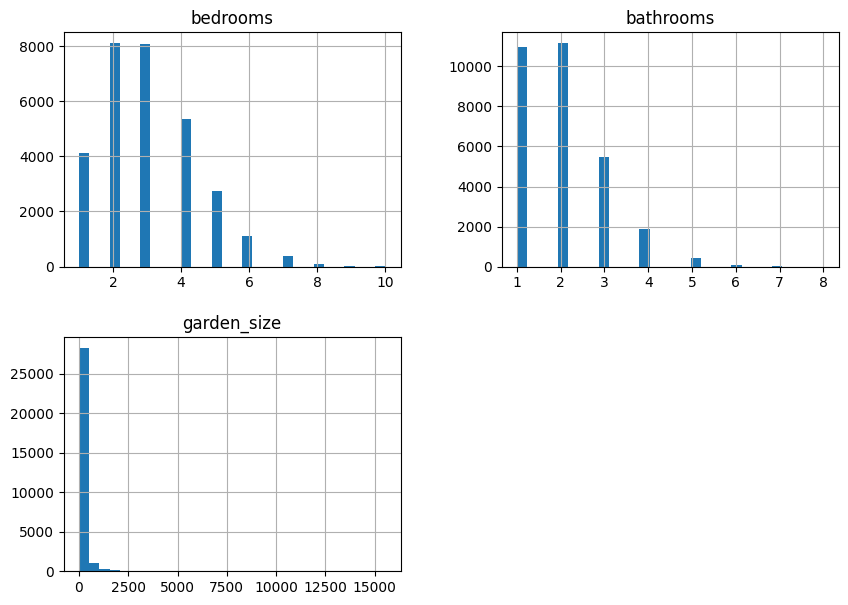

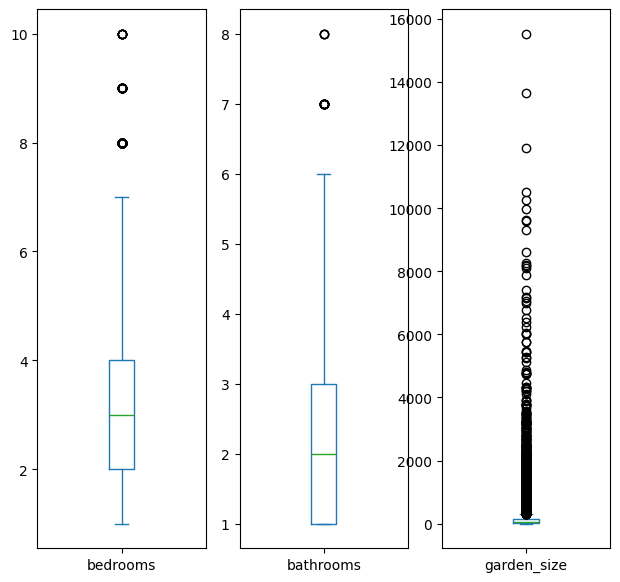

In [227]:
import matplotlib.pyplot as plt

# Histograms for numeric columns
df[numerical_cols_regression].hist(bins=30, figsize=(10, 7))
plt.show()

# Box plots for numeric columns to check for outliers
df[numerical_cols_regression].plot(kind='box', figsize=(10, 7), subplots=True, layout=(1, len(numerical_cols)))
plt.show()


In [228]:
# Display a random sample of the DataFrame
print(df.sample(10))


          house_type      price  bedrooms  bathrooms neighbourhood_quality  \
18271       Terraced  662299.35         4          1                 Rough   
5328        Bungalow  443421.51         3          3           Outstanding   
15660           Flat  132907.38         3          1               Alright   
19462       Detached  488340.62         5          2               Alright   
16439  Semi-Detached   68638.91         2          1              Pleasant   
13085  Semi-Detached  234929.85         3          3                 Rough   
625             Flat  739200.91         2          2           Outstanding   
15841       Terraced  776300.89         2          1                 Rough   
3869   Semi-Detached  246691.66         2          2               Alright   
29873       Bungalow  119204.33         4          3              Pleasant   

      house_condition    crime_rate  garden_size             city  Cluster  
18271     Outstanding        Medium        43.99        Thurnsco

In [229]:
# Display the remaining columns to ensure 'house_keywords' is removed
print(df.columns)


Index(['house_type', 'price', 'bedrooms', 'bathrooms', 'neighbourhood_quality',
       'house_condition', 'crime_rate', 'garden_size', 'city', 'Cluster'],
      dtype='object')


In [230]:
# Train the regression pipeline
pipeline_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['house_type',
                                                   'neighbourhood_quality',
                                                   'house_condition',
                                                   'crime_rate', 'city']),
                                                 ('num', StandardScaler(),
                                                  ['bedrooms', 'bathrooms',
                                                   'garden_size'])])),
                ('regressor', DecisionTreeRegressor(random_state=42))])

In [231]:

#  evaluate the model
y_pred = pipeline_regression.predict(X_test)
print("Predicted Prices:", y_pred)

Predicted Prices: [411865.92 185455.5  122753.2  ... 852898.87 262552.62 488559.17]


In [235]:
def recommend_houses(df, user_preferences, pipeline):
    # Define default values for missing preferences
    default_values = {
        'bedrooms': df['bedrooms'].median(),
        'bathrooms': df['bathrooms'].median(),
        'house_type': df['house_type'].mode()[0],
        'city': df['city'].mode()[0],
        'neighbourhood_quality': df['neighbourhood_quality'].mode()[0],
        'house_condition': df['house_condition'].mode()[0],
        'crime_rate': df['crime_rate'].mode()[0],
        'garden_size': df['garden_size'].median(),
        'price': df['price'].median()  # Use median price for internal logic, not exposed to user
    }

    # Extract strictness preferences and remove them from user_preferences
    strict_criteria = user_preferences.pop('strict', [])

    # Merge user preferences with defaults
    complete_preferences = {**default_values, **user_preferences}

    # Extract and remove budget for price filtering
    budget = complete_preferences.pop('budget')

    # Prepare DataFrame for clustering
    user_df = pd.DataFrame([complete_preferences])
    user_df_transformed = pipeline['preprocessor'].transform(user_df)
    user_cluster = pipeline['cluster'].predict(user_df_transformed)[0]

    # Start filtering within cluster and under budget
    query = (df['Cluster'] == user_cluster) & (df['price'] <= budget) & (df['city'] == complete_preferences['city'])

    # Apply strict criteria
    for criterion in strict_criteria:
        if criterion in complete_preferences:
            query &= (df[criterion] == complete_preferences[criterion])

    # Get recommended houses with a score for matching the house type
    recommended_houses = df[query].copy()
    recommended_houses['score'] = (recommended_houses['house_type'] == complete_preferences['house_type']).astype(int)
    
    # Return the top 10 matches sorted by score and price
    recommended_houses = recommended_houses.sort_values(by=['score', 'price'], ascending=[False, True]).head(10)

    if recommended_houses.empty:
        return "No houses found that match your preferences within your budget."
    else:
        return recommended_houses[['bedrooms', 'bathrooms', 'house_type', 'city', 'price', 'score']]

# Example user preferences including a budget
user_preferences = {
    'bedrooms': 3,
    'bathrooms': 2,
    'city': 'London',
    'house_type': 'Terraced',
    'budget': 700000,
    'strict': ['city', 'bedrooms', 'bathrooms']  # User specifies that these criteria are strict
}

# Get recommendations 
recommended_houses = recommend_houses(df, user_preferences, pipeline_clustering)
print("Recommended houses based on your preferences:")
print(recommended_houses)


Recommended houses based on your preferences:
       bedrooms  bathrooms house_type    city      price  score
3733          3          2   Terraced  London   41151.04      1
29032         3          2   Terraced  London   53639.77      1
4731          3          2   Terraced  London   55724.51      1
21542         3          2   Terraced  London   72909.68      1
22145         3          2   Terraced  London  109790.29      1
4971          3          2   Terraced  London  115967.45      1
17224         3          2   Terraced  London  118278.01      1
24083         3          2   Terraced  London  121041.51      1
3315          3          2   Terraced  London  121465.28      1
16296         3          2   Terraced  London  124260.45      1
